In [5]:
from google.colab import drive
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
f = open('/content/drive/My Drive/pim.txt')
pim = f.readline()
pim = pim.split('\t')
pim = np.array(list(map(lambda x: float(x), pim)))
f.close()
f = open('/content/drive/My Drive/u1.txt')
u1 = f.readline()
u1 = u1.split('\t')
u1 = np.array(list(map(lambda x: float(x), u1)))
f.close()

In [4]:
K = 1000
L = 300

In [6]:
s1 = pim[:K].reshape((K,1))
s2 = u1[:K].reshape((K,1))

In [7]:
a1 = np.random.randn(1,L)
a2 = np.random.randn(1,L)

In [8]:
X = s1 @ a1 + s2 @ a2

In [9]:
I1 = 10
J1 = 100
I2 = 50
J2 = 20

In [10]:
def lowrank(vec,rank,I,J):
    matr = vec.reshape((I,J))
    u, s, vh = np.linalg.svd(matr)
    u_ = u[:,:rank]
    s_ = np.diag(s[:rank])
    vh_ = vh[:rank,:]
    matr_ = u_ @ s_ @ vh_
    return matr_.reshape((I*J,1))

In [11]:
R1 = 3
R2 = 4
T1 = 5
T2 = 6

In [29]:
def step1(z,UV2,AB1,UV1,beta,lambd1,lambd2):
    z = z.reshape((K,1))
    func = np.linalg.norm(X - z @ a1 - UV2 @ a2) ** 2 + 0.5 * beta * np.linalg.norm(z - AB1 + lambd1/beta) ** 2 + 0.5 * beta * np.linalg.norm(z - UV1 + lambd2/beta) ** 2
    return func

In [18]:
def sae(s1, s2):
    return min(np.arccos((s1.T @ s2) / (np.linalg.norm(s1) * np.linalg.norm(s2))) ** 2, np.arccos((s1.T @ -s2) / (np.linalg.norm(s1) * np.linalg.norm(s2))) ** 2)

In [32]:
def step2(z,UV2,AB2,UV1,beta,lambd3,lambd4):
    z = z.reshape((K,1))
    func = np.linalg.norm(X - UV1 @ a1 - z @ a2) ** 2 + 0.5 * beta * np.linalg.norm(z - AB2 + lambd3/beta) ** 2 + 0.5 * beta * np.linalg.norm(z - UV2 + lambd4/beta) ** 2
    return func

In [33]:
def admm(s1=s1,s2=s2,R1=R1,R2=R2,T1=T1,T2=T2,maxiter=100):
    c1 = np.zeros((K,1)) + 1e-10
    c2 = np.zeros((K,1)) + 1e-10
    UV1 = lowrank(c1,R1,I1,J1)
    UV2 = lowrank(c2,R2,I1,J1)
    AB1 = lowrank(c1,T1,I2,J2)
    AB2 = lowrank(c2,T2,I2,J2)
    beta = 1e-4
    lambd1 = np.zeros((K,1))
    lambd2 = np.zeros((K,1))
    lambd3 = np.zeros((K,1))
    lambd4 = np.zeros((K,1))
    sae01 = sae(c1,s1)
    sae02 = sae(c2,s2)
    i = 0
    while i < maxiter:
        res = minimize(step1, c1, args=(UV2,AB1,UV1,beta,lambd1,lambd2),method='CG',options={'maxiter':1})
        c1 = res.x
        UV1 = lowrank(c1,R1,I1,J1)
        AB1 = lowrank(c1,T1,I2,J2)
        res = minimize(step2, c2, args=(UV2,AB2,UV1,beta,lambd3,lambd4),method='CG', options={'maxiter':1})
        c2 = res.x
        UV2 = lowrank(c2,R2,I1,J1)
        AB2 = lowrank(c2,T2,I2,J2)
        lambd1 += beta * (c1.reshape((K,1)) - AB1)
        lambd2 += beta * (c1.reshape((K,1)) - UV1)
        lambd3 += beta * (c2.reshape((K,1)) - AB2)
        lambd4 += beta * (c2.reshape((K,1)) - UV2)
        sae1 = sae(c1,s1)
        sae2 = sae(c2,s2)
        if ((sae01 - sae1 < 1e-10) and (sae02 - sae2 < 1e-10)):
            break
        sae01 = sae1
        sae02 = sae2
        i += 1
    return c1, c2, sae1, sae2

In [34]:
c1, c2, sae1, sae2 = admm()

In [35]:
print(sae1,sae2)

[2.50866672e-06] [0.00107639]


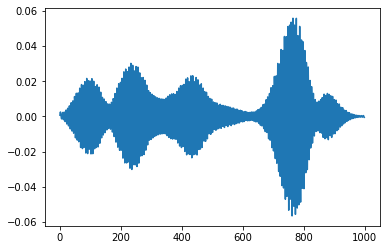

In [36]:
plt.plot(s1)

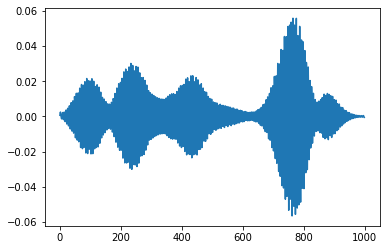

In [37]:
plt.plot(c1)

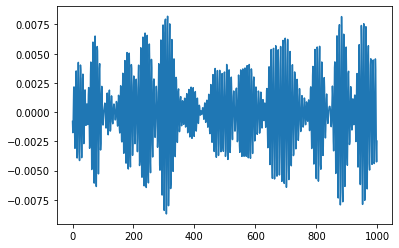

In [38]:
plt.plot(s2)

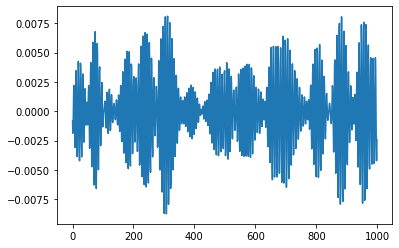

In [39]:
plt.plot(c2)